In [27]:
import mdtraj as md
import numpy as np

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
import deeptime.markov.msm as msm
import deeptime.markov.hmm as hmm

from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz
from deeptime.markov.sample import *
from deeptime.util import energy2d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from funcs_objective import *
from funcs_validate_msm import *

In [4]:
ftraj_dir = Path('./archived/ftraj_egfr')
ftraj_files = natsorted([ftraj for ftraj in ftraj_dir.rglob('run*-clone?_dunbrack.npy')])
print(len(ftraj_files))

traj_dir = Path('/home/rzhu/storage_SRS/trajectories/aws2/')
traj_files = natsorted([traj for traj in traj_dir.rglob('run*-clone?.h5')])
print(len(traj_files))

3462
3474


In [5]:
study_name = "markovlag_100ns"
key = 'random_trials'
markov_lag = 100
hp_idx = 60
model_name = 'top_t2_from_random'
seed = 42

data_path = Path(f'data_egfr/{study_name}_{key}/{hp_idx}/')
data_path.mkdir(parents=True, exist_ok=True)

In [14]:
study_name = "markovlag_100ns"
key = 'random_trials'
markov_lag = 100
hp_idx = 60
model_name = 'top_t2_from_random'
seed = 42

data_path = Path(f'data_egfr/{study_name}_{key}/{hp_idx}/')
data_path.mkdir(parents=True, exist_ok=True)

hps = pd.read_hdf(f'data_egfr/{study_name}.h5', key=f'{key}_hps')
hp_dict = Adict(hps[hps.trial__no == hp_idx].to_dict('records')[0])
hp_dict

{'trial__no': 60,
 'trajlen__cutoff': 1000,
 'tica__lag': 23,
 'tica__dim': 10,
 'tica__stride': 10,
 'cluster__k': 780,
 'cluster__maxiter': 1000,
 'cluster__stride': 100}

---

In [16]:
# test 
seed=42
markov_lag = 100
hp_dict = {'trial__no': 60,
            'trajlen__cutoff': 1000,
            'tica__lag': 23,
            'tica__dim': 8,
            'tica__stride': 10,
            'cluster__k': 780,
            'cluster__maxiter': 1000,
            'cluster__stride': 100}
hp_dict = Adict(hp_dict)
hp_dict

{'trial__no': 60,
 'trajlen__cutoff': 1000,
 'tica__lag': 23,
 'tica__dim': 8,
 'tica__stride': 10,
 'cluster__k': 780,
 'cluster__maxiter': 1000,
 'cluster__stride': 100}

In [143]:
ftrajs, traj_mapping = get_data(hp_dict, ftraj_dir=ftraj_dir)
ttrajs, tica_mod = tica(hp_dict, ftrajs)
dtrajs, kmeans_mod = kmeans(hp_dict, ttrajs, seed=seed)
# msm_mod = msm.MaximumLikelihoodMSM(reversible=True, lagtime=markov_lag).fit_fetch(dtrajs)
msm_bay = msm.BayesianMSM(n_samples=50, reversible=True, lagtime=markov_lag).fit_fetch(dtrajs)
msm_mod = msm_bay.prior

ttraj_cat = np.concatenate(ttrajs, axis=0)
dtrajs_cat = np.concatenate(dtrajs, axis=0)
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


Loaded 1983 ftrajs.


100%|██████████| 1983/1983 [00:02<00:00, 903.22it/s]                        
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:36<00:00, 27.34it/s] 
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|██████████| 1983/1983 [00:13<00:00, 152.09it/s]                                    


In [38]:
its_data = its_convergence(dtrajs, lagtimes=[1,10,50,100,200,500,1000])

100%|██████████| 7/7 [1:11:12<00:00, 610.41s/it]


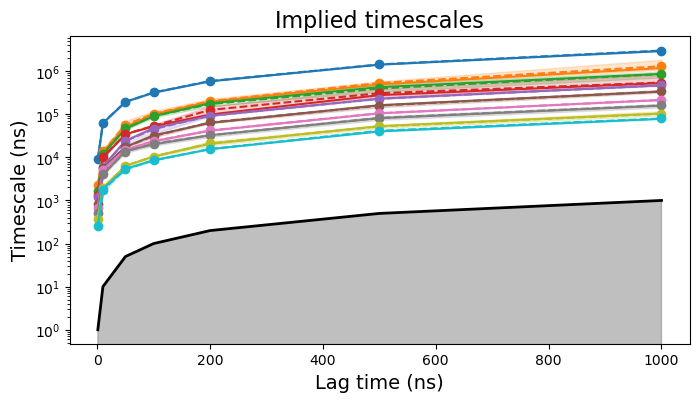

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_implied_timescales(its_data, n_its=10, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales', fontsize=16)
ax.set_xlabel('Lag time (ns)', fontsize=14)
ax.set_ylabel('Timescale (ns)', fontsize=14)

plt.savefig(data_path.joinpath('its_test.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

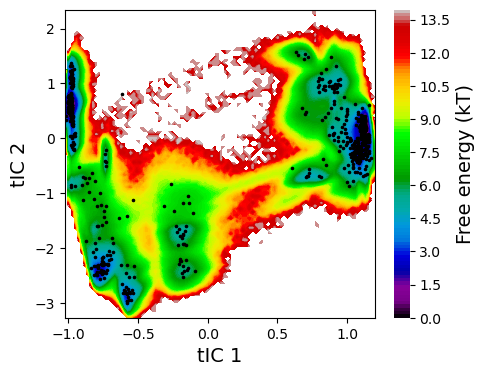

In [16]:

fig, ax = plt.subplots(figsize=(5, 4))
ax, contour, cbar = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax, contourf_kws=dict(cmap='nipy_spectral'))
ax.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=10, c='black', marker='.')
ax.set_xlabel('tIC 1', fontsize=14)
ax.set_ylabel('tIC 2', fontsize=14)
cbar.ax.set_ylabel('Free energy (kT)', fontsize=14)

plt.savefig(data_path.joinpath('free_energy.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

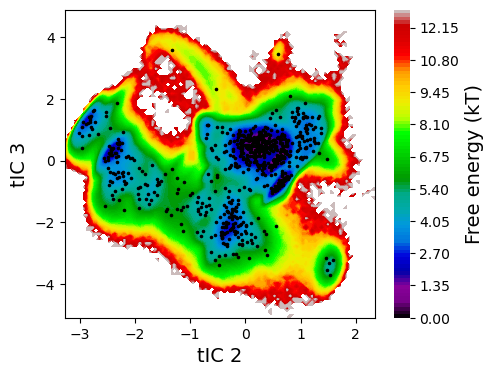

In [17]:
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)
ttraj_cat = np.concatenate(ttrajs, axis=0)

fig, ax = plt.subplots(figsize=(5, 4))
ax, contour, cbar = plot_energy2d(energy2d(ttraj_cat[:,1], ttraj_cat[:,2], weights=np.concatenate(traj_weights,axis=0)), ax=ax, contourf_kws=dict(cmap='nipy_spectral'))
ax.scatter(kmeans_mod.cluster_centers_[:,1], kmeans_mod.cluster_centers_[:,2], s=10, c='black', marker='.')

ax.set_xlabel('tIC 2', fontsize=14)
ax.set_ylabel('tIC 3', fontsize=14)
cbar.ax.set_ylabel('Free energy (kT)', fontsize=14)

#plt.savefig(data_path.joinpath('free_energy.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

### Coarse-grain with PCCA

In [150]:
n_states = 4
pcca_mod = msm_mod.pcca(n_states)
pcca_mod.coarse_grained_stationary_probability

array([0.01308236, 0.20431116, 0.38277362, 0.39983285])

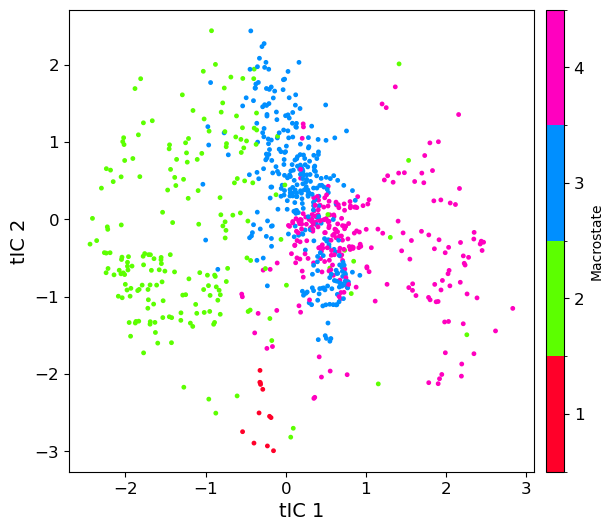

In [190]:
cmap = mpl.colormaps['gist_rainbow'].resampled(n_states)
norm = colors.BoundaryNorm(list(range(0,n_states+1)), n_states, clip=True)

fig, ax=plt.subplots(1,1,figsize=(6, 6))
s = ax.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], 
               c=pcca_mod.assignments, s=6, cmap=cmap, norm=norm)
ax.set_xlabel('tIC 1', fontsize=14)
ax.set_ylabel('tIC 2', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

cbar_ax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
cbar = plt.colorbar(s, cax=cbar_ax, label='Macrostate')
cbar.set_ticks(np.arange(n_states) + 0.5)
cbar.set_ticklabels(np.arange(n_states)+1)
cbar.ax.tick_params(labelsize=12)

#plt.savefig(data_path.joinpath('macrostate_assignment.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

### TO COMPLETE: REINDEX STATES according to tIC1 values

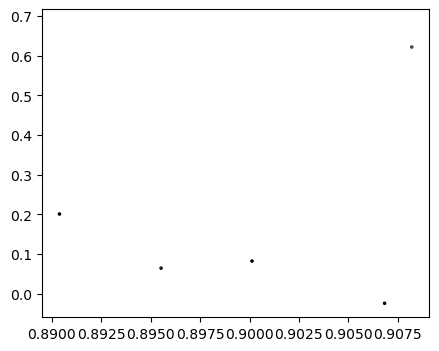

In [19]:
s = 0
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(kmeans_mod.cluster_centers_[:,0][pcca_mod.assignments == s], kmeans_mod.cluster_centers_[:,1][pcca_mod.assignments == s], s=10, c=pcca_mod.metastable_distributions[0,:][pcca_mod.assignments == s], marker='.', cmap='grey')

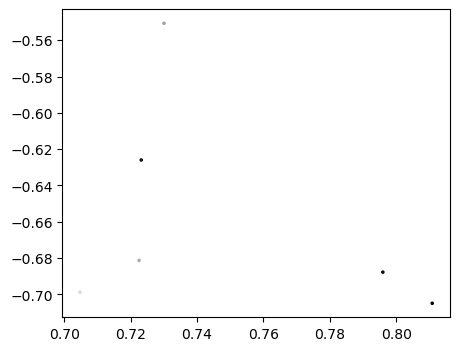

In [20]:
s = 1
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(kmeans_mod.cluster_centers_[:,0][pcca_mod.assignments == s], kmeans_mod.cluster_centers_[:,1][pcca_mod.assignments == s], s=10, c=pcca_mod.metastable_distributions[0,:][pcca_mod.assignments == s], marker='.', cmap='grey')

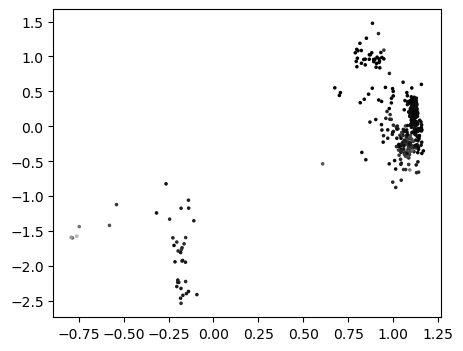

In [21]:
s = 2
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(kmeans_mod.cluster_centers_[:,0][pcca_mod.assignments == s], kmeans_mod.cluster_centers_[:,1][pcca_mod.assignments == s], s=10, c=pcca_mod.metastable_distributions[0,:][pcca_mod.assignments == s], marker='.', cmap='grey')

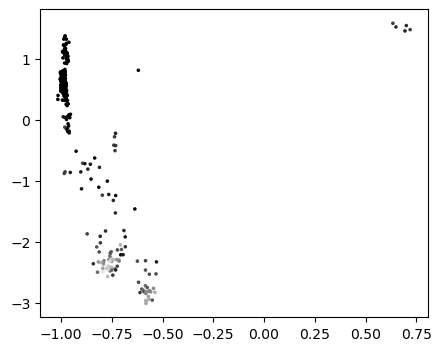

In [22]:
s = 3
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(kmeans_mod.cluster_centers_[:,0][pcca_mod.assignments == s], kmeans_mod.cluster_centers_[:,1][pcca_mod.assignments == s], s=10, c=pcca_mod.metastable_distributions[0,:][pcca_mod.assignments == s], marker='.', cmap='grey')

### Sample from PCCA coarse-grained states

In [104]:
macrostate_to_sample = 2
membership_cutoff = 0.9

memberships = pcca_mod.memberships[:,macrostate_to_sample]
states_to_sample = memberships > membership_cutoff

stationary_distribution = msm_mod.stationary_distribution
stationary_distribution[~states_to_sample] = 0
sample_distribution = stationary_distribution / np.sum(stationary_distribution)

frame_of_states = compute_index_states(dtrajs)
state_samples_count = sample_states_by_distribution(sample_distribution, 2)
state_samples_count

In [109]:
frames = save_sampled_conf(state_samples_count, frame_of_states, traj_mapping, ftraj_files, traj_dir, Path('data/test_samples.pdb'))

Loading trajectories


  0%|          | 0/2 [00:00<?, ?it/s]/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
100%|██████████| 2/2 [05:52<00:00, 176.46s/it]


### Coarse-grained transition matrix and MFPT matrix

In [152]:
transition_matrix_coarse = pcca_mod.coarse_grained_transition_matrix

In [157]:
pcca_mod.sets[0]

array([  7,  53, 143, 179, 198, 295, 490, 500, 695, 725, 741, 777])

In [159]:
mfpt_mean = np.zeros([n_states, n_states])
mfpt_std = np.zeros([n_states, n_states])

for i in range(n_states):
    for j in range(n_states):
        mfpt_mean[i,j] = msm_bay.gather_stats('mfpt', A=pcca_mod.sets[i], B=pcca_mod.sets[j]).mean
        mfpt_std[i,j] = msm_bay.gather_stats('mfpt', A=pcca_mod.sets[i], B=pcca_mod.sets[j]).std

In [189]:
mfpt_mean

array([[     0.        ,  86115.60809098,  21101.54505309,
          9295.44314326],
       [519266.43898438,      0.        ,  41016.67721855,
         38450.25687383],
       [522355.07736798, 110778.92151075,      0.        ,
         15676.47661771],
       [519407.83657603, 107914.84644255,  13840.42237387,
             0.        ]])

/tmp/ipykernel_7432/2892657353.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


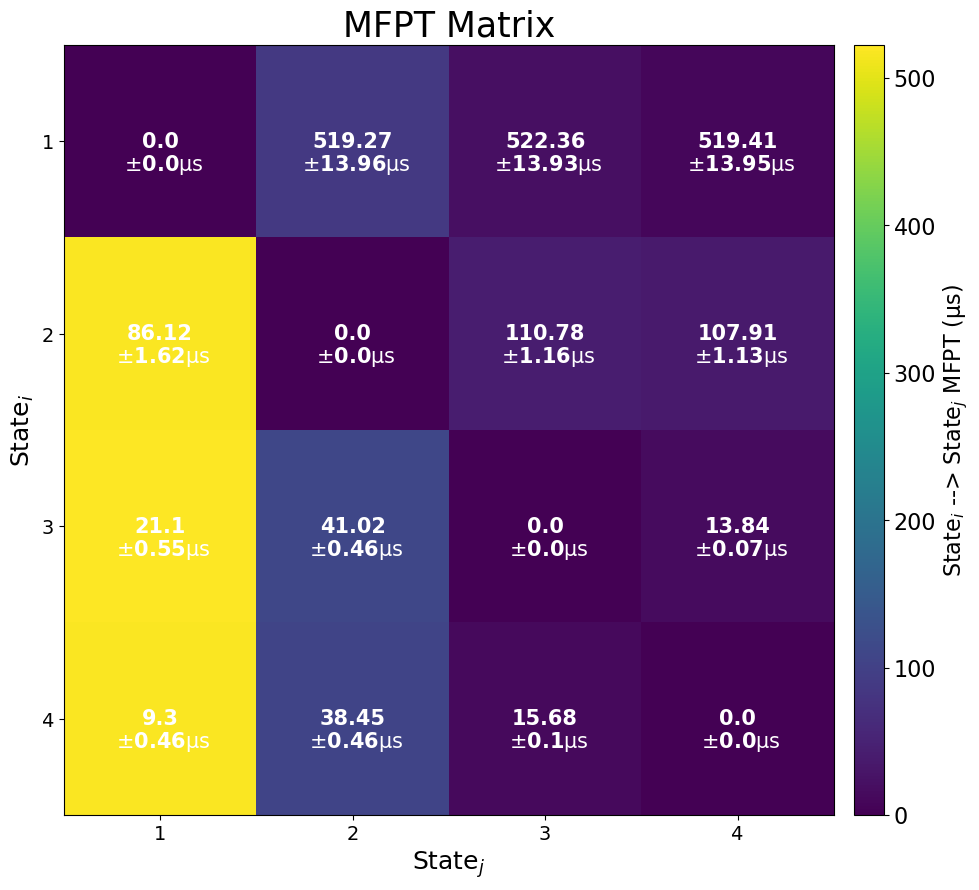

In [191]:
cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=np.min(mfpt_mean/1000), vmax=np.max(mfpt_mean/1000))

fig,ax = plt.subplots(1,figsize=(10,10))
s = ax.imshow(mfpt_mean/1000, cmap=cmap, norm=norm)
for i in range(n_states):
    for j in range(n_states):
        val = str(round(mfpt_mean[i,j]/1000,2))
        err = str(round(mfpt_std[i,j]/1000,2))
        
        ax.text(i, j,"{}".format(val),
                va='center', ha='center', color='white', size=15, weight="bold")
        ax.text(i, j,"\n\n $\pm${}{}".format(err, r'$\mathrm{\mu s}$'),
                va='center', ha='center', color='white', size=15, weight="bold")   
                
cbar_ax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
cbar = plt.colorbar(s, cax=cbar_ax)

ax.set_xlabel('State$_j$', fontsize=18)
ax.set_ylabel('State$_i$', fontsize=18)
ax.set_xticks(np.arange(n_states))
ax.set_yticks(np.arange(n_states))
ax.set_xticklabels(np.arange(n_states)+1, fontsize=14)
ax.set_yticklabels(np.arange(n_states)+1, fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('MFPT Matrix', fontsize=25)

cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel(r'State$_i$ --> State$_j$ MFPT ($\mathrm{\mu s}$)', fontsize=16)


plt.show()

### Eigenvectors

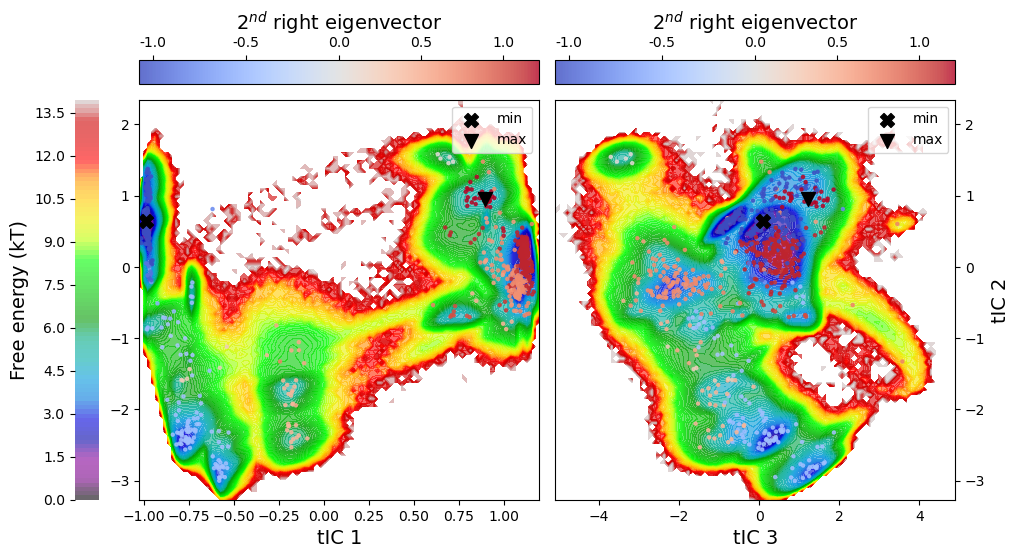

In [90]:
eigenvec_2 = msm_mod.eigenvectors_right()[:,1]

vmin, vmax = min(eigenvec_2), max(eigenvec_2)
divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

min_id, max_id = eigenvec_2.argmin(), eigenvec_2.argmax()

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_axes([0, 0, 0.5, 0.5])
ax2 = fig.add_axes([0.52, 0, 0.5, 0.5])
fe_cax = fig.add_axes([ax1.get_position().x0-0.08, ax1.get_position().y0, 0.03, ax1.get_position().height])
ev1_cax = fig.add_axes([ax1.get_position().x0, ax1.get_position().y1+0.02, ax1.get_position().width, 0.03])
ev2_cax = fig.add_axes([ax2.get_position().x0, ax2.get_position().y1+0.02, ax2.get_position().width, 0.03])

ax1, contour1, cbar1 = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax1, cbar_ax=fe_cax, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))
ax2, contour1, cbar2 = plot_energy2d(energy2d(ttraj_cat[:,2], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax2, cbar=False, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))

ax1_eg2 = ax1.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_2, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax1.scatter(kmeans_mod.cluster_centers_[min_id,0], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax1.scatter(kmeans_mod.cluster_centers_[max_id,0], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax1_eg2, cax=ev1_cax, format='%.1f', orientation='horizontal')

ax2_eg2 = ax2.scatter(kmeans_mod.cluster_centers_[:,2], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_2, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax2.scatter(kmeans_mod.cluster_centers_[min_id,2], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax2.scatter(kmeans_mod.cluster_centers_[max_id,2], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax2_eg2, cax=ev2_cax, format='%.1f', orientation='horizontal')

ev1_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ev2_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ax2.tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
fe_cax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)

ax1.set_xlabel('tIC 1', fontsize=14)
ax1.legend()
ax2.set_xlabel('tIC 3', fontsize=14)
ax2.set_ylabel('tIC 2', fontsize=14)
ax2.yaxis.set_label_position("right")
ax2.legend()
ev1_cax.set_xlabel(r'$2^{nd}$ right eigenvector', fontsize=14)
ev2_cax.set_xlabel(r'$2^{nd}$ right eigenvector', fontsize=14)
ev1_cax.xaxis.set_label_position('top')
ev2_cax.xaxis.set_label_position('top')
fe_cax.set_ylabel('Free energy (kT)', fontsize=14)
fe_cax.yaxis.set_label_position("left")

plt.savefig(data_path.joinpath('eigenvector_2.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

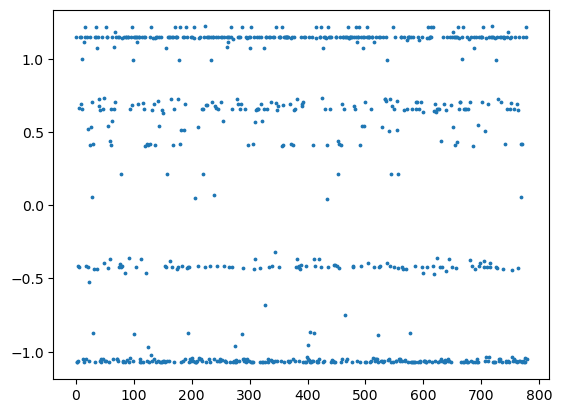

In [102]:
plt.scatter(list(range(len(eigenvec_2))),eigenvec_2, s=3)

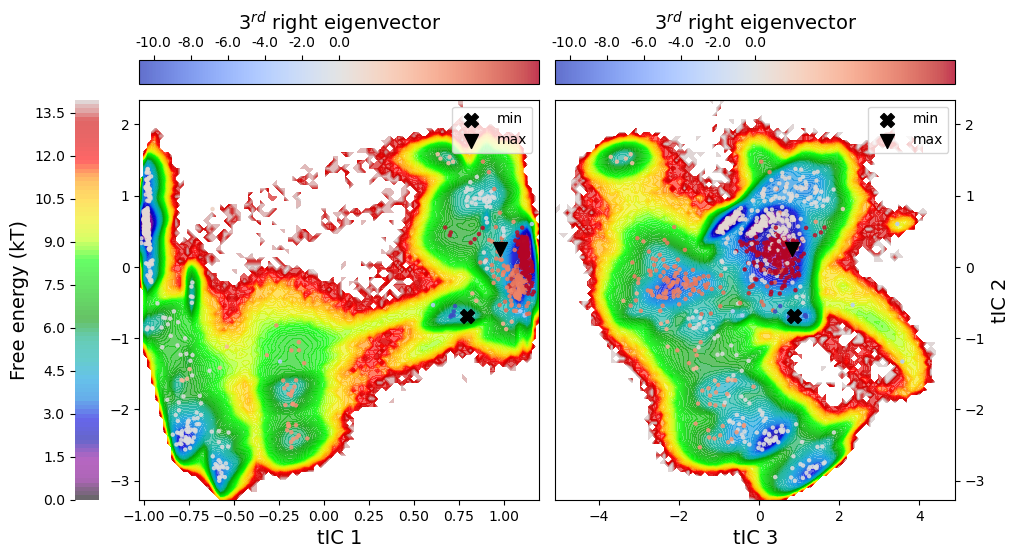

In [95]:
eigenvec_3 = msm_mod.eigenvectors_right()[:,2]

vmin, vmax = min(eigenvec_3), max(eigenvec_3)
divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

min_id, max_id = eigenvec_3.argmin(), eigenvec_3.argmax()

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_axes([0, 0, 0.5, 0.5])
ax2 = fig.add_axes([0.52, 0, 0.5, 0.5])
fe_cax = fig.add_axes([ax1.get_position().x0-0.08, ax1.get_position().y0, 0.03, ax1.get_position().height])
ev1_cax = fig.add_axes([ax1.get_position().x0, ax1.get_position().y1+0.02, ax1.get_position().width, 0.03])
ev2_cax = fig.add_axes([ax2.get_position().x0, ax2.get_position().y1+0.02, ax2.get_position().width, 0.03])

ax1, contour1, cbar1 = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax1, cbar_ax=fe_cax, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))
ax2, contour1, cbar2 = plot_energy2d(energy2d(ttraj_cat[:,2], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax2, cbar=False, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))

ax1_eg2 = ax1.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_3, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax1.scatter(kmeans_mod.cluster_centers_[min_id,0], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax1.scatter(kmeans_mod.cluster_centers_[max_id,0], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax1_eg2, cax=ev1_cax, format='%.1f', orientation='horizontal')

ax2_eg2 = ax2.scatter(kmeans_mod.cluster_centers_[:,2], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_3, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax2.scatter(kmeans_mod.cluster_centers_[min_id,2], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax2.scatter(kmeans_mod.cluster_centers_[max_id,2], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax2_eg2, cax=ev2_cax, format='%.1f', orientation='horizontal')

ev1_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ev2_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ax2.tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
fe_cax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)

ax1.set_xlabel('tIC 1', fontsize=14)
ax1.legend()
ax2.set_xlabel('tIC 3', fontsize=14)
ax2.set_ylabel('tIC 2', fontsize=14)
ax2.yaxis.set_label_position("right")
ax2.legend()
ev1_cax.set_xlabel(r'$3^{rd}$ right eigenvector', fontsize=14)
ev2_cax.set_xlabel(r'$3^{rd}$ right eigenvector', fontsize=14)
ev1_cax.xaxis.set_label_position('top')
ev2_cax.xaxis.set_label_position('top')
fe_cax.set_ylabel('Free energy (kT)', fontsize=14)
fe_cax.yaxis.set_label_position("left")

plt.savefig(data_path.joinpath('eigenvector_3.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

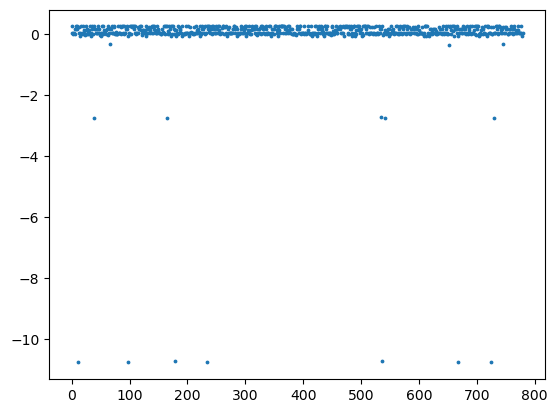

In [101]:
plt.scatter(list(range(len(eigenvec_3))),eigenvec_3, s=3)

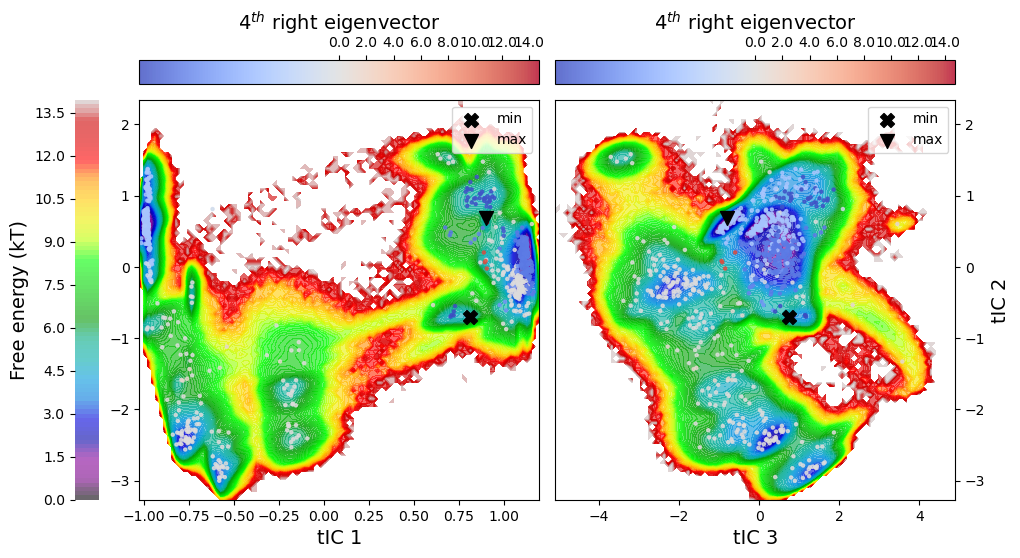

In [107]:
eigenvec_4 = msm_mod.eigenvectors_right()[:,3]

vmin, vmax = min(eigenvec_4), max(eigenvec_4)
divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

min_id, max_id = eigenvec_4.argmin(), eigenvec_4.argmax()

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_axes([0, 0, 0.5, 0.5])
ax2 = fig.add_axes([0.52, 0, 0.5, 0.5])
fe_cax = fig.add_axes([ax1.get_position().x0-0.08, ax1.get_position().y0, 0.03, ax1.get_position().height])
ev1_cax = fig.add_axes([ax1.get_position().x0, ax1.get_position().y1+0.02, ax1.get_position().width, 0.03])
ev2_cax = fig.add_axes([ax2.get_position().x0, ax2.get_position().y1+0.02, ax2.get_position().width, 0.03])

ax1, contour1, cbar1 = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax1, cbar_ax=fe_cax, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))
ax2, contour1, cbar2 = plot_energy2d(energy2d(ttraj_cat[:,2], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax2, cbar=False, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))

ax1_eg4 = ax1.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_4, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax1.scatter(kmeans_mod.cluster_centers_[min_id,0], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax1.scatter(kmeans_mod.cluster_centers_[max_id,0], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax1_eg4, cax=ev1_cax, format='%.1f', orientation='horizontal')

ax2_eg4 = ax2.scatter(kmeans_mod.cluster_centers_[:,2], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_4, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax2.scatter(kmeans_mod.cluster_centers_[min_id,2], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax2.scatter(kmeans_mod.cluster_centers_[max_id,2], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax2_eg4, cax=ev2_cax, format='%.1f', orientation='horizontal')

ev1_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ev2_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ax2.tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
fe_cax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)

ax1.set_xlabel('tIC 1', fontsize=14)
ax1.legend()
ax2.set_xlabel('tIC 3', fontsize=14)
ax2.set_ylabel('tIC 2', fontsize=14)
ax2.yaxis.set_label_position("right")
ax2.legend()
ev1_cax.set_xlabel(r'$4^{th}$ right eigenvector', fontsize=14)
ev2_cax.set_xlabel(r'$4^{th}$ right eigenvector', fontsize=14)
ev1_cax.xaxis.set_label_position('top')
ev2_cax.xaxis.set_label_position('top')
fe_cax.set_ylabel('Free energy (kT)', fontsize=14)
fe_cax.yaxis.set_label_position("left")

plt.savefig(data_path.joinpath('eigenvector_4.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

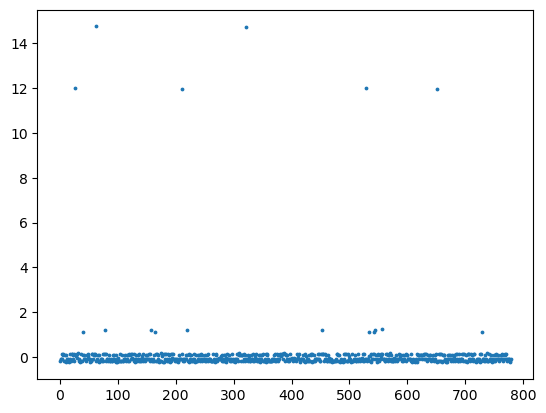

In [108]:
plt.scatter(list(range(len(eigenvec_4))),eigenvec_4, s=3)

a
